In [9]:
import sys
sys.path.append('/home/esp/data_analyze/05.02.2025/code')

import pandas as pd
import microbiome_analysis as ma
import microbiome_subgroup_analysis as msa

import warnings
warnings.filterwarnings('ignore')


# Настройка путей и переменных
MAIN_DIR = '05.02.2025'
PART_OF_PATH = 'only_phylum_subgroup_v2'
GROUP_LIST = ['OB-BPD/DS ', 'CHJ-BPD/DS+', 'CHJ-BPD/DS-', 'CN/SD ']
SUPGROUP_LIST = ['MAM-J', 'MAM-I', 'MAMLI', 'MAM-D', 'Fecal']

DF = pd.read_csv(
    f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/out_data/{PART_OF_PATH}_out.csv',
    sep='\t',
    index_col=[0]
)

PATH_TO_ALPHA_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/alpha/data'
PATH_TO_ALPHA_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/alpha/figure'
PATH_TO_BETA_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/beta/data'
PATH_TO_BETA_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/beta/figure'
PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/relative_abundance/data'
PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/relative_abundance/figure'
PATH_TO_VENN_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/venn/figure'
PATH_TO_FB_OUTPUT_DATA = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/fb/data'
PATH_TO_FB_OUTPUT_FIGURE = f'/home/esp/data_analyze/{MAIN_DIR}/data/output/{PART_OF_PATH}/fb/figure'

SAFE_DATA = True
SHOW = True

#groups = DF['GROUP'].unique()
PALETTE = {GROUP_LIST[0]: '#1924B1', GROUP_LIST[1]: '#74E600', GROUP_LIST[2]:'#7200e6', GROUP_LIST[3]:'#b1a619'}
ma.PALETTE = PALETTE
ma.GROUP_LIST = GROUP_LIST

ma.PATH_TO_ALPHA_OUTPUT_DATA = PATH_TO_ALPHA_OUTPUT_DATA
ma.PATH_TO_ALPHA_OUTPUT_FIGURE = PATH_TO_ALPHA_OUTPUT_FIGURE
ma.PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA  = PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_DATA
ma.PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE = PATH_TO_RELATIVE_ABUNDANCE_OUTPUT_FIGURE
ma.PATH_TO_VENN_OUTPUT_FIGURE = PATH_TO_VENN_OUTPUT_FIGURE
ma.PATH_TO_BETA_OUTPUT_DATA = PATH_TO_BETA_OUTPUT_DATA
ma.PATH_TO_BETA_OUTPUT_FIGURE = PATH_TO_BETA_OUTPUT_FIGURE
ma.PATH_TO_FB_OUTPUT_FIGURE = PATH_TO_FB_OUTPUT_FIGURE
ma.PATH_TO_FB_OUTPUT_DATA = PATH_TO_FB_OUTPUT_DATA
ma.SHOW = SHOW
ma.SAFE_DATA = SAFE_DATA


In [10]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import itertools

def filter_taxa_by_prevalence(df, 
                              abundance_col='RelativeAbundance', 
                              sample_col='#SampleID', 
                              taxonomy_col='Taxonomy',
                              presence_threshold=0.01, 
                              min_samples_fraction=0.1):
    n_samples = df[sample_col].nunique()
    presence_counts = (
        df[df[abundance_col] >= presence_threshold]
        .groupby(taxonomy_col)[sample_col]
        .nunique()
    )
    min_count = int(np.ceil(n_samples * min_samples_fraction))
    prevalent_taxa = presence_counts[presence_counts >= min_count].index
    filtered_df = df[df[taxonomy_col].isin(prevalent_taxa)].copy()
    return filtered_df

def remove_outliers_iqr(df, group_col, value_col, factor=1.5):
    filtered_list = []
    outliers_list = []
    
    for g, sub_df in df.groupby(group_col):
        Q1 = sub_df[value_col].quantile(0.25)
        Q3 = sub_df[value_col].quantile(0.75)
        iqr = Q3 - Q1
        lower = Q1 - factor * iqr
        upper = Q3 + factor * iqr
        
        mask = sub_df[value_col].between(lower, upper)
        filtered_list.append(sub_df[mask])
        outliers_list.append(sub_df[~mask])
    
    return pd.concat(filtered_list), pd.concat(outliers_list)

def test_taxa_kruskal_fdr(df, group_col='GROUP', value_col='RelativeAbundance', taxonomy_col='Taxonomy'):
    results = []
    unique_taxa = df[taxonomy_col].unique()

    for taxon in unique_taxa:
        df_taxon = df[df[taxonomy_col] == taxon]
        grouped_data = [
            df_taxon.loc[df_taxon[group_col] == g, value_col].dropna().values
            for g in df[group_col].unique()
        ]
        if all(len(arr) > 0 for arr in grouped_data):
            stat, p_val = kruskal(*grouped_data)
            results.append((taxon, p_val))

    if len(results) > 0:
        taxa, pvals = zip(*results)
        pvals_corrected = multipletests(pvals, alpha=0.05, method='fdr_bh')[1]
        results_df = pd.DataFrame({
            taxonomy_col: taxa,
            'p_value_raw': pvals,
            'p_value_fdr': pvals_corrected
        })
        return results_df.sort_values('p_value_fdr')
    else:
        return pd.DataFrame(columns=[taxonomy_col, 'p_value_raw', 'p_value_fdr'])



df_filtered = filter_taxa_by_prevalence(DF, 
                                        presence_threshold=0.01, 
                                        min_samples_fraction=0.1)

df_filtered["Taxonomy"] = "k_" + df_filtered["Taxonomy"]


results_kruskal = test_taxa_kruskal_fdr(df_filtered, 'GROUP', 'RelativeAbundance', 'Taxonomy')
df_filtered.shape

(1463, 7)

In [12]:
def filter_taxa_by_level(df, taxonomy_col='Taxonomy', level='genus'):
    """
    Фильтрует таксоны по заданному уровню (например, genus, family, species).

    Параметры:
    ----------
    df : pd.DataFrame
        DataFrame с колонкой, содержащей таксономию.
    taxonomy_col : str, optional
        Название колонки с таксономией (по умолчанию 'Taxonomy').
    level : str, optional
        Уровень таксономии, который нужно оставить. Допустимые значения:
        'phylum', 'class', 'order', 'family', 'genus', 'species'.
        По умолчанию 'genus'.

    Возвращает:
    -----------
    pd.DataFrame
        DataFrame с отфильтрованными таксонами.
    """
    level_prefixes = {
        'kingdom': 'k_',
        'phylum': 'p_',
        'class': 'c_',
        'order': 'o_',
        'family': 'f_',
        'genus': 'g_',
        'species': 's_'
    }

    if level not in level_prefixes:
        raise ValueError(f"Неподдерживаемый уровень таксономии: {level}. "
                         f"Допустимые значения: {list(level_prefixes.keys())}")

    prefix = level_prefixes[level]

    df_filtered = df.copy()
    
    # Оставляем только нужный уровень
    df_filtered[taxonomy_col] = df_filtered[taxonomy_col].apply(
        lambda x: '|'.join([part for part in x.split('|') if part.startswith(prefix)]) if isinstance(x, str) else x
    )
    
    # Удаляем строки, где после фильтрации `Taxonomy` пуст
    df_filtered = df_filtered[df_filtered[taxonomy_col] != '']

    # Удаление дубликатов (если они возникли после фильтрации)
    df_filtered = df_filtered.drop_duplicates(subset=['#SampleID', taxonomy_col])

    return df_filtered



In [13]:
df_filtered_phylum = filter_taxa_by_level(df_filtered, taxonomy_col='Taxonomy', level='phylum')
print(df_filtered_phylum.shape)
df_filtered_phylum.head()


(1463, 7)


#SampleID            Taxonomy       GROUP Subgroup  Value  Total  \
1        10A     p_Euryarchaeota  OB-BPD/DS     MAM-J      0  92085   
6        10A    p_Actinobacteria  OB-BPD/DS     MAM-J    195  92085   
7        10A  p_Actinobacteriota  OB-BPD/DS     MAM-J   1928  92085   
9        10A      p_Bacteroidota  OB-BPD/DS     MAM-J     44  92085   
13       10A  p_Campylobacterota  OB-BPD/DS     MAM-J  14482  92085   

    RelativeAbundance  
1            0.000000  
6            0.002118  
7            0.020937  
9            0.000478  
13           0.157268


=== Analyzing Subgroup: MAM-J ===

=== SHANNON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.276112   3.0  0.643728  0.594144
Residual  3.574390  25.0       NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1621  0.8201 -0.6747  0.3504   False
1  CHJ-BPD/DS+       CN/SD    -0.2063  0.6886 -0.7188  0.3063   False
2  CHJ-BPD/DS+   OB-BPD/DS     0.0239  0.9994 -0.5458  0.5935   False
3  CHJ-BPD/DS-       CN/SD    -0.0441  0.9962 -0.6001  0.5118   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.1860  0.8349 -0.4230  0.7950   False


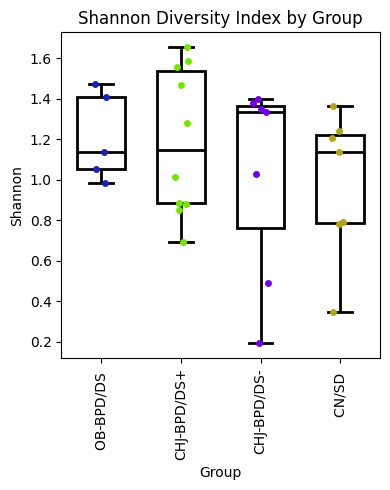


=== SIMPSON ANOVA ===
             sum_sq    df         F   PR(>F)
C(GROUP)  0.099898   3.0  0.951657  0.43078
Residual  0.874777  25.0       NaN      NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1072  0.6548 -0.3608  0.1463   False
1  CHJ-BPD/DS+       CN/SD    -0.1098  0.6380 -0.3634  0.1438   False
2  CHJ-BPD/DS+   OB-BPD/DS     0.0235  0.9956 -0.2583  0.3053   False
3  CHJ-BPD/DS-       CN/SD    -0.0026  1.0000 -0.2776  0.2725   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.1307  0.6364 -0.1705  0.4320   False


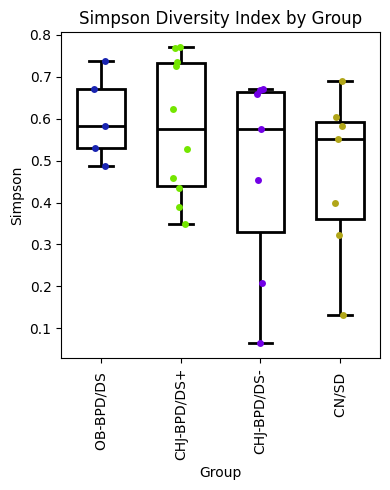


=== OBSERVED ANOVA ===
              sum_sq    df         F    PR(>F)
C(GROUP)   3.105419   3.0  1.063083  0.382455
Residual  24.342857  25.0       NaN       NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.4286  0.8145 -1.7662  0.9090   False
1  CHJ-BPD/DS+       CN/SD     0.2857  0.9349 -1.0519  1.6233   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.6000  0.6868 -2.0867  0.8867   False
3  CHJ-BPD/DS-       CN/SD     0.7143  0.5385 -0.7365  2.1651   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.1714  0.9907 -1.7607  1.4179   False


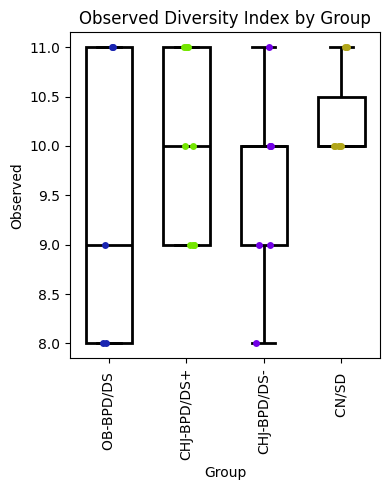


=== PIELOU_E ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.062289   3.0  0.746782  0.534417
Residual  0.695080  25.0       NaN       NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.0580  0.8939 -0.2840  0.1680   False
1  CHJ-BPD/DS+       CN/SD    -0.0935  0.6699 -0.3196  0.1325   False
2  CHJ-BPD/DS+   OB-BPD/DS     0.0326  0.9841 -0.2186  0.2838   False
3  CHJ-BPD/DS-       CN/SD    -0.0356  0.9780 -0.2807  0.2096   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.0906  0.7905 -0.1780  0.3591   False


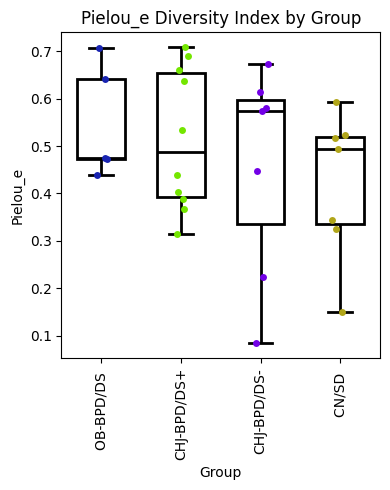

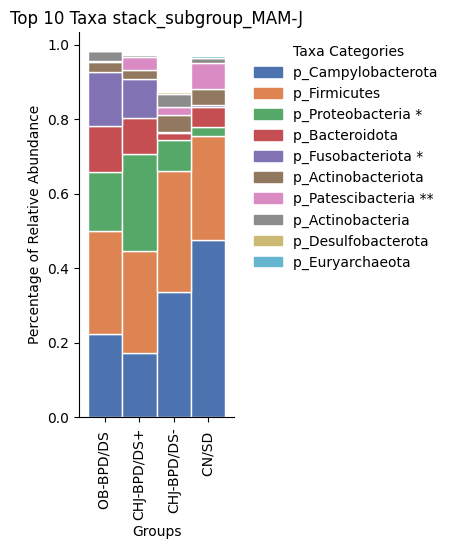

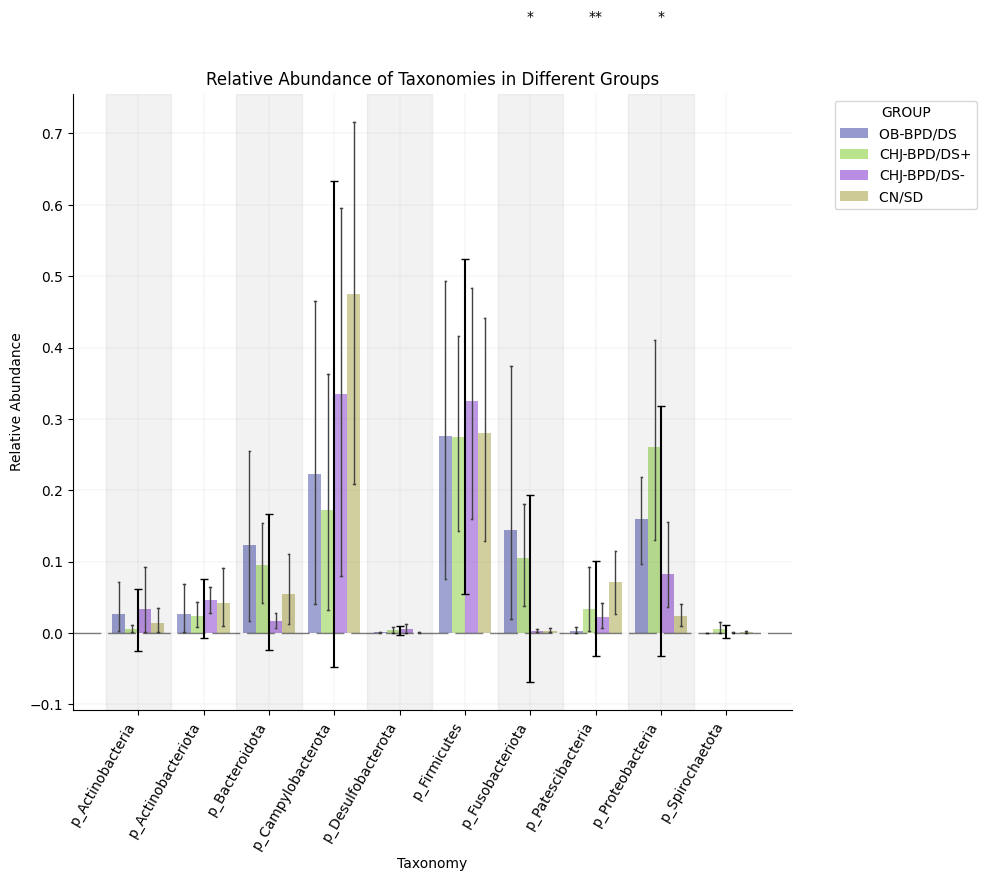

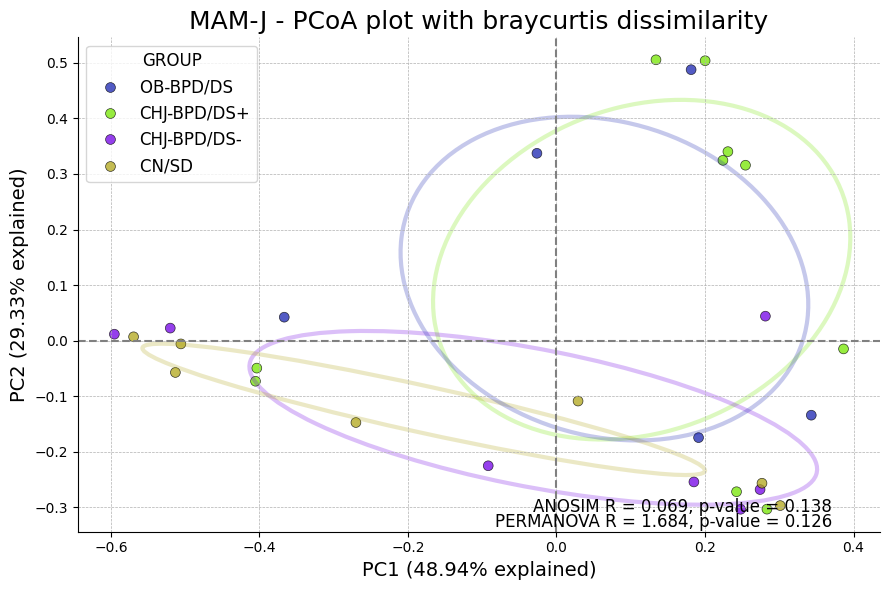

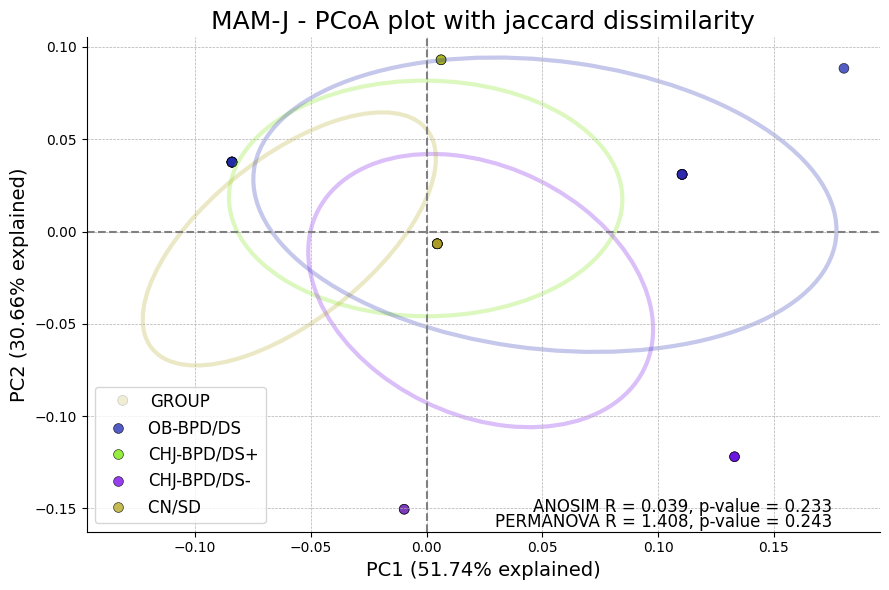

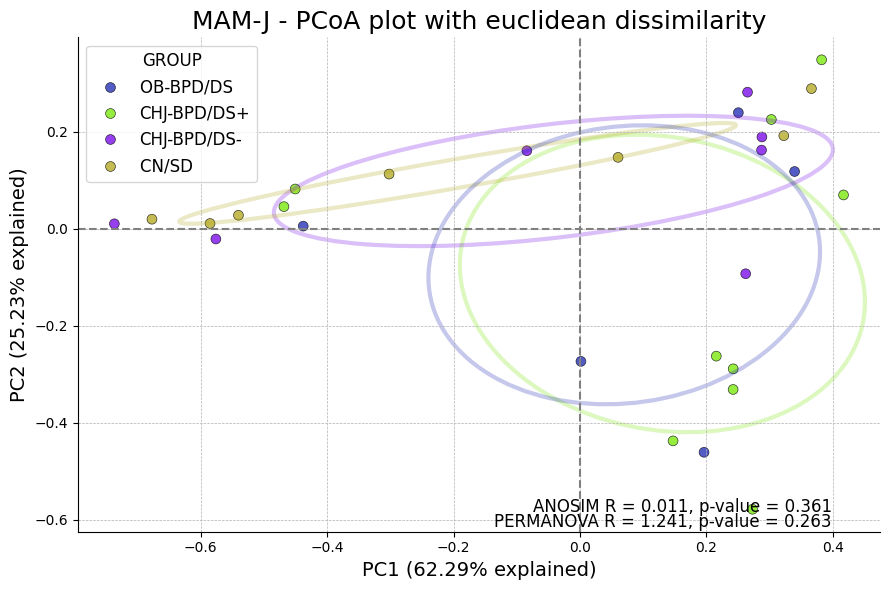

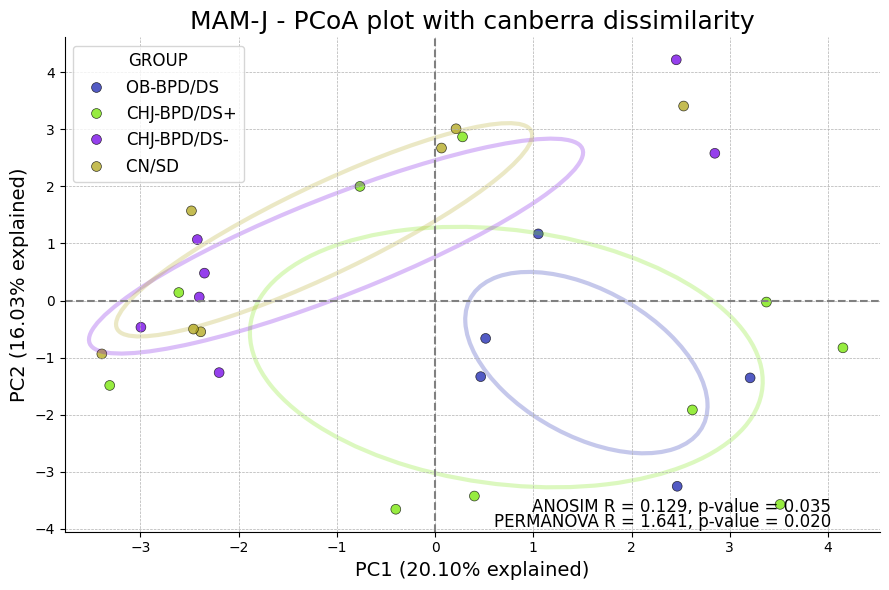

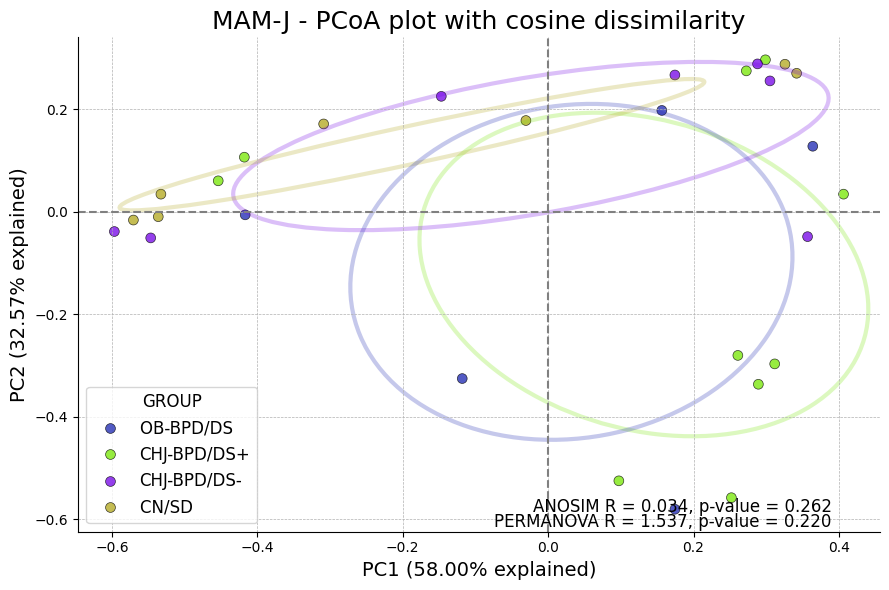


=== Analyzing Subgroup: MAM-I ===

=== SHANNON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.789486   3.0  2.092755  0.128974
Residual  2.892229  23.0       NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.4374  0.0960 -0.9319  0.0572   False
1  CHJ-BPD/DS+       CN/SD    -0.1714  0.7960 -0.6886  0.3458   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0939  0.9639 -0.6412  0.4535   False
3  CHJ-BPD/DS-       CN/SD     0.2660  0.5430 -0.2800  0.8119   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.3435  0.3696 -0.2311  0.9181   False


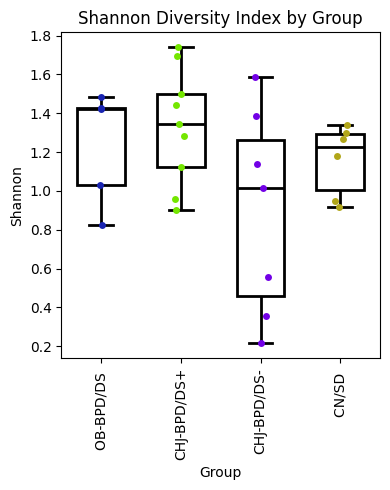


=== SIMPSON ANOVA ===
             sum_sq    df        F    PR(>F)
C(GROUP)  0.214101   3.0  2.45441  0.088831
Residual  0.668771  23.0      NaN       NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.2206  0.0756 -0.4584  0.0172   False
1  CHJ-BPD/DS+       CN/SD    -0.0710  0.8584 -0.3197  0.1777   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0202  0.9965 -0.2834  0.2430   False
3  CHJ-BPD/DS-       CN/SD     0.1496  0.4105 -0.1129  0.4122   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.2004  0.2144 -0.0759  0.4767   False


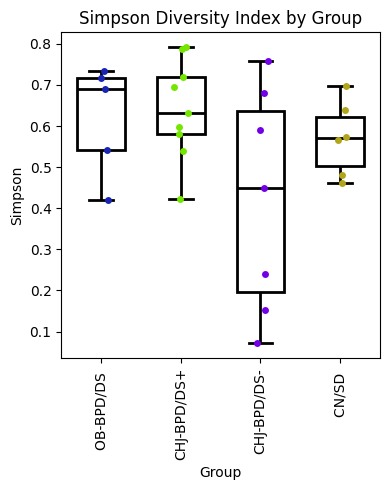


=== OBSERVED ANOVA ===
              sum_sq    df         F    PR(>F)
C(GROUP)   2.694709   3.0  1.343322  0.284864
Residual  15.379365  23.0       NaN       NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.5873  0.4971 -1.7277  0.5531   False
1  CHJ-BPD/DS+       CN/SD     0.0556  0.9992 -1.1371  1.2482   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.6444  0.5043 -1.9066  0.6177   False
3  CHJ-BPD/DS-       CN/SD     0.6429  0.5042 -0.6161  1.9018   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.0571  0.9994 -1.3822  1.2679   False


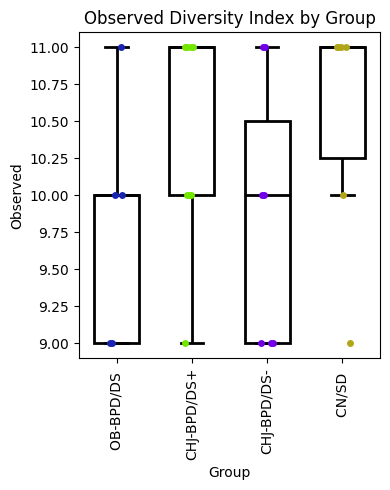


=== PIELOU_E ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.133131   3.0  1.903036  0.157292
Residual  0.536338  23.0       NaN       NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1763  0.1296 -0.3892  0.0367   False
1  CHJ-BPD/DS+       CN/SD    -0.0715  0.8106 -0.2943  0.1512   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0245  0.9915 -0.2602  0.2112   False
3  CHJ-BPD/DS-       CN/SD     0.1047  0.6130 -0.1304  0.3398   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.1518  0.3476 -0.0956  0.3992   False


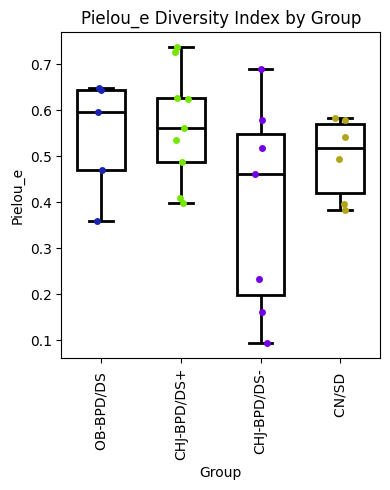

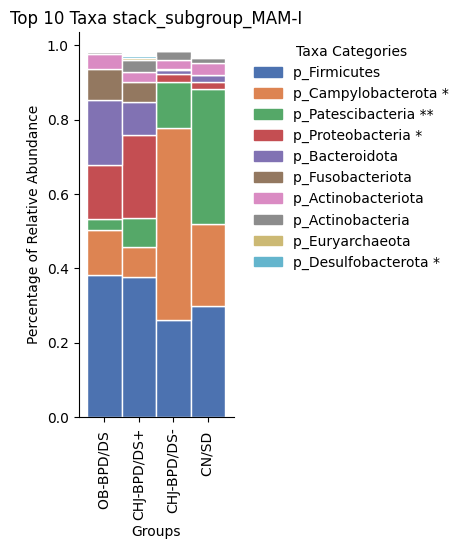

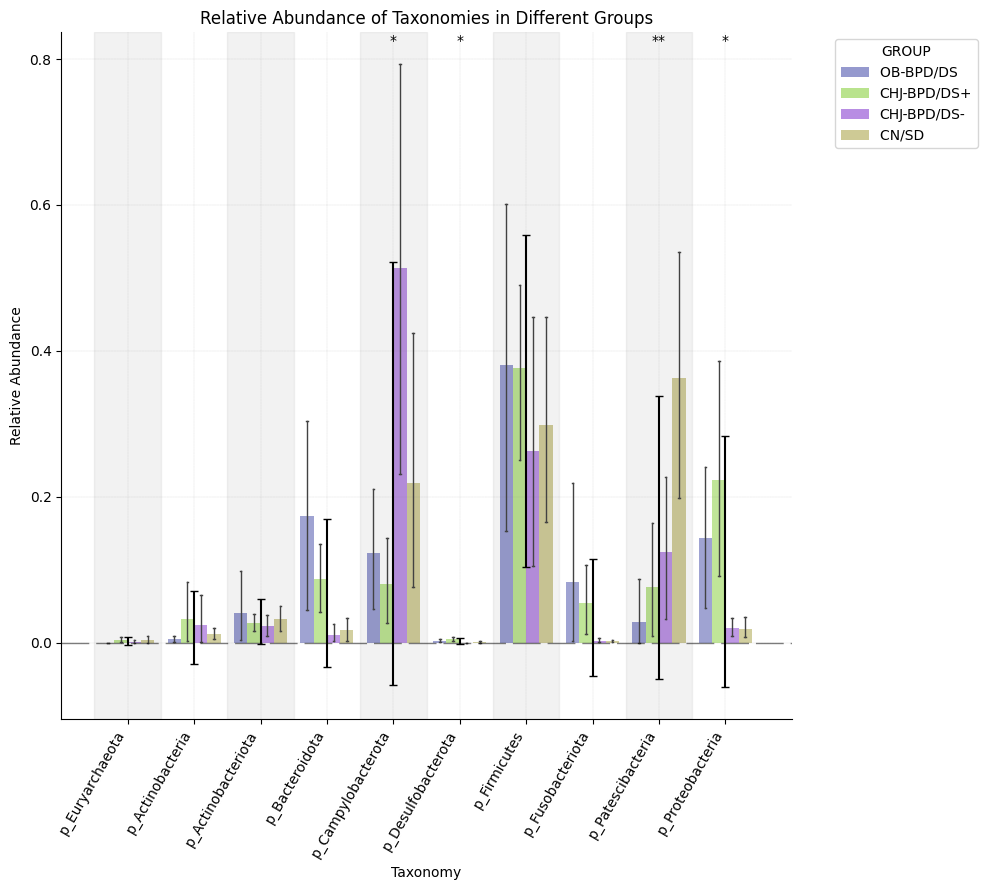

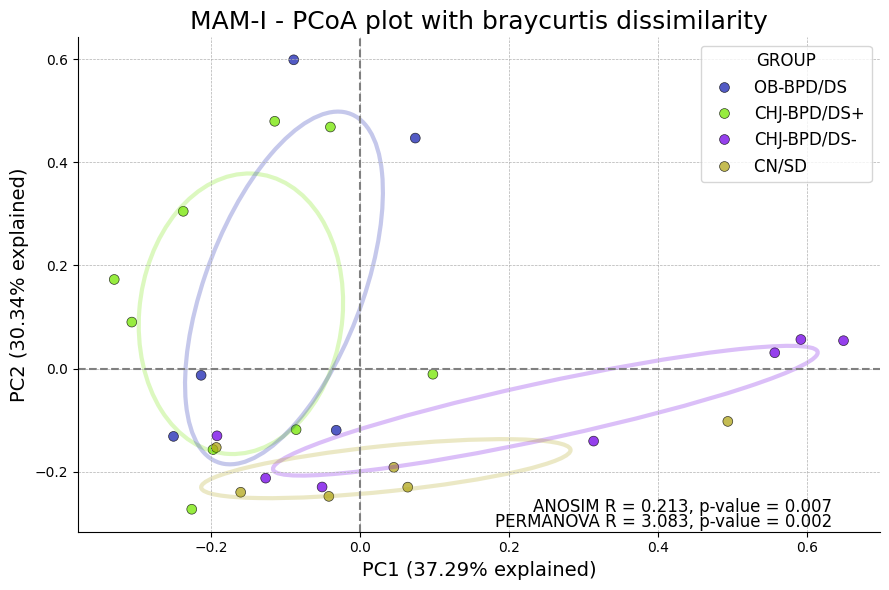

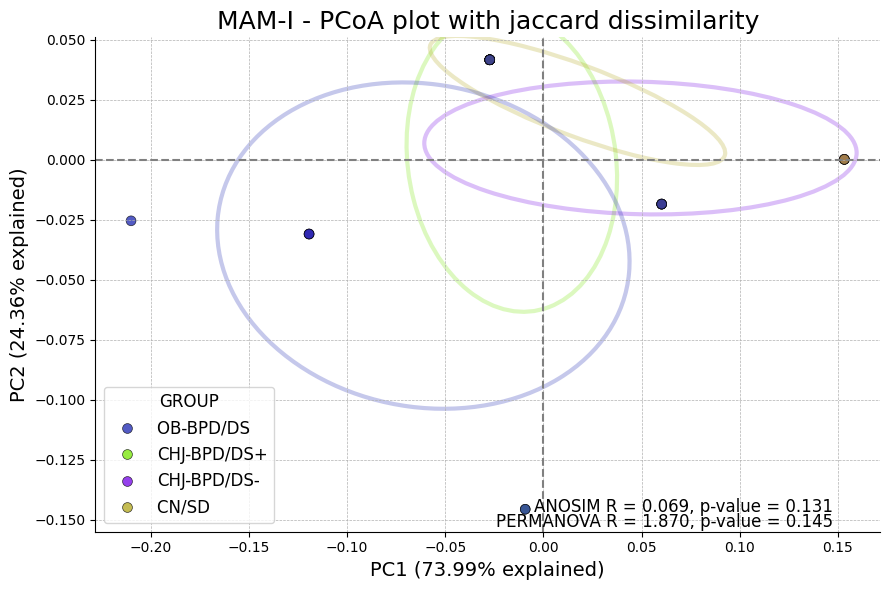

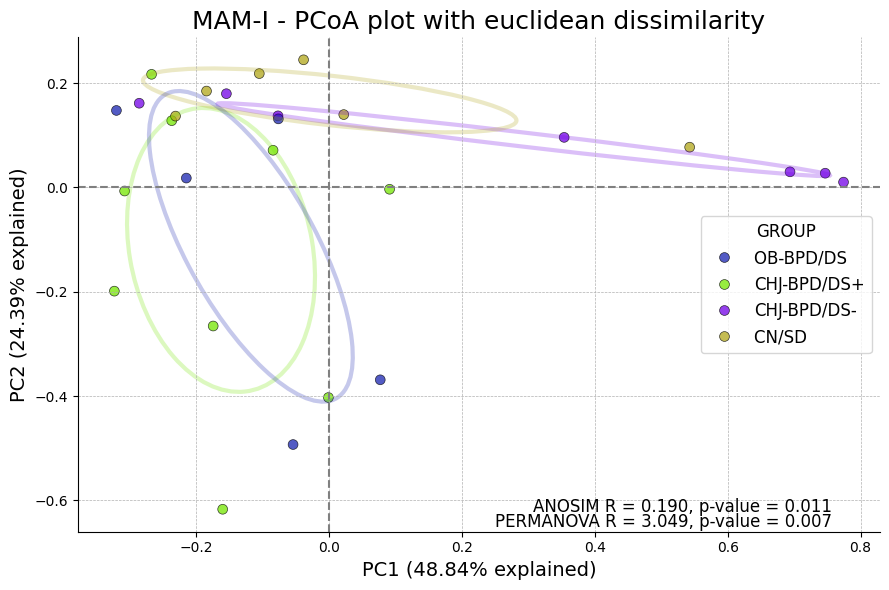

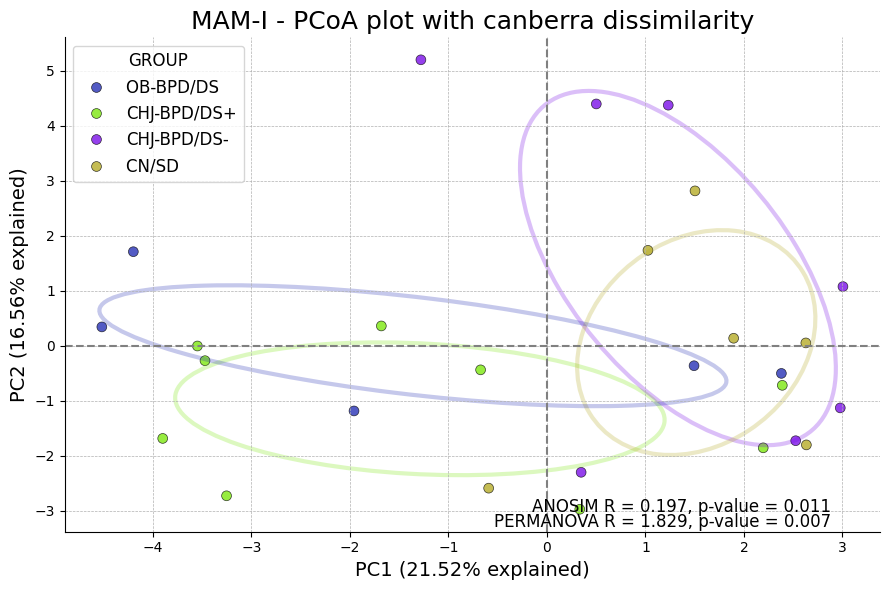

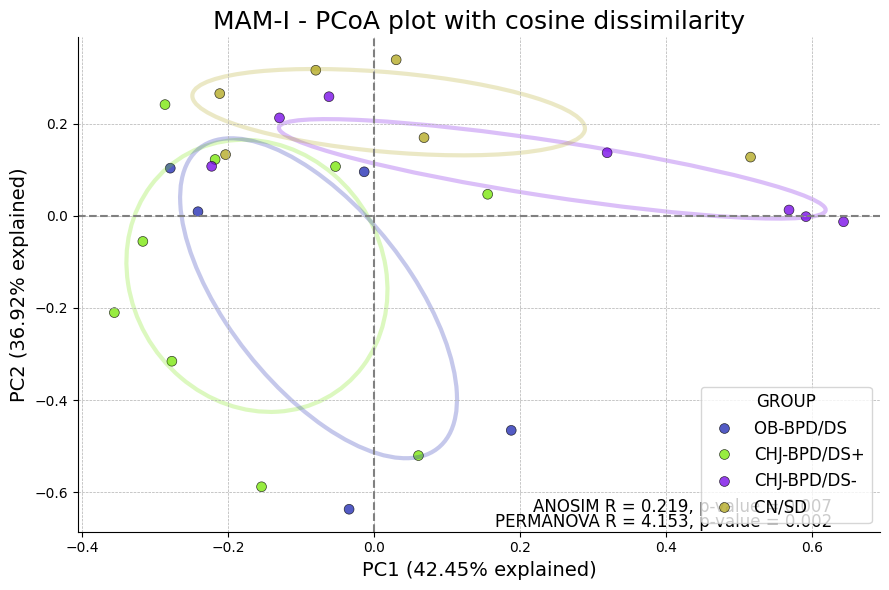


=== Analyzing Subgroup: MAMLI ===

=== SHANNON ANOVA ===
             sum_sq    df         F   PR(>F)
C(GROUP)  0.721828   3.0  1.924771  0.15252
Residual  3.000159  24.0       NaN      NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.2429  0.5534 -0.7465  0.2608   False
1  CHJ-BPD/DS+       CN/SD    -0.4087  0.1156 -0.8894  0.0719   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.1401  0.8868 -0.6743  0.3942   False
3  CHJ-BPD/DS-       CN/SD    -0.1658  0.8334 -0.7085  0.3768   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.1028  0.9627 -0.4878  0.6934   False


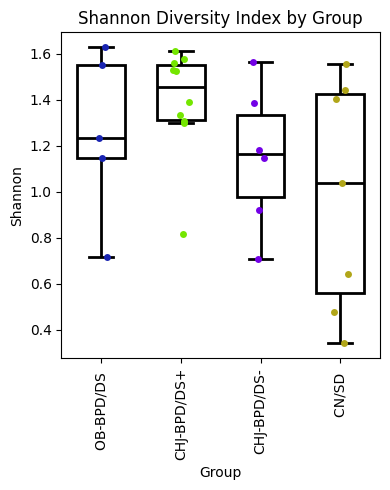


=== SIMPSON ANOVA ===
             sum_sq    df        F    PR(>F)
C(GROUP)  0.154614   3.0  1.63352  0.207938
Residual  0.757205  24.0      NaN       NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.0959  0.7250 -0.3489  0.1571   False
1  CHJ-BPD/DS+       CN/SD    -0.1855  0.1757 -0.4270  0.0560   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0292  0.9904 -0.2975  0.2392   False
3  CHJ-BPD/DS-       CN/SD    -0.0896  0.8013 -0.3622  0.1830   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.0667  0.9246 -0.2300  0.3634   False


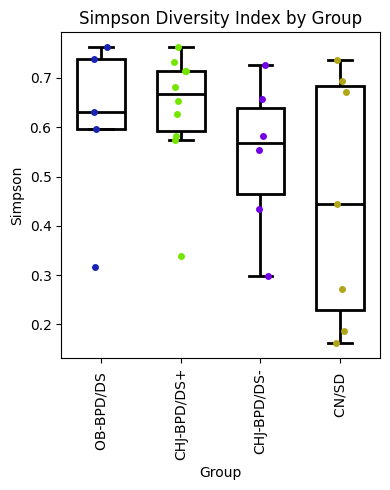


=== OBSERVED ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.923810   3.0  0.754864  0.530373
Residual  9.790476  24.0       NaN       NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.0667  0.9970 -0.9765  0.8432   False
1  CHJ-BPD/DS+       CN/SD    -0.0429  0.9991 -0.9111  0.8254   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.5000  0.4941 -1.4650  0.4650   False
3  CHJ-BPD/DS-       CN/SD     0.0238  0.9999 -0.9564  1.0041   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.4333  0.6808 -1.5002  0.6336   False


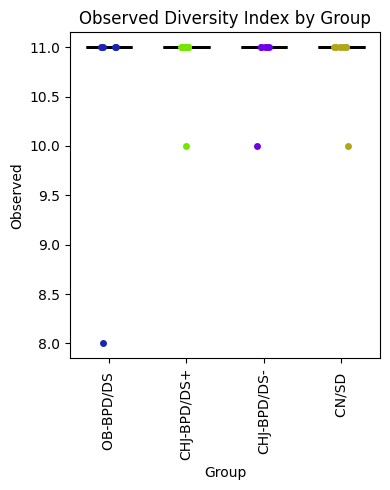


=== PIELOU_E ANOVA ===
             sum_sq    df         F  PR(>F)
C(GROUP)  0.123562   3.0  1.956413  0.1475
Residual  0.505261  24.0       NaN     NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1007  0.5455 -0.3073  0.1060   False
1  CHJ-BPD/DS+       CN/SD    -0.1680  0.1147 -0.3653  0.0292   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0507  0.9188 -0.2699  0.1686   False
3  CHJ-BPD/DS-       CN/SD    -0.0674  0.8375 -0.2900  0.1553   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.0500  0.9404 -0.1924  0.2923   False


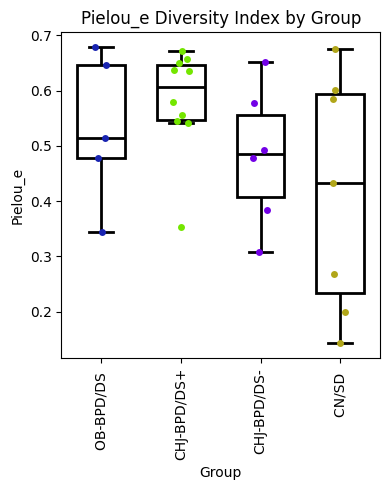

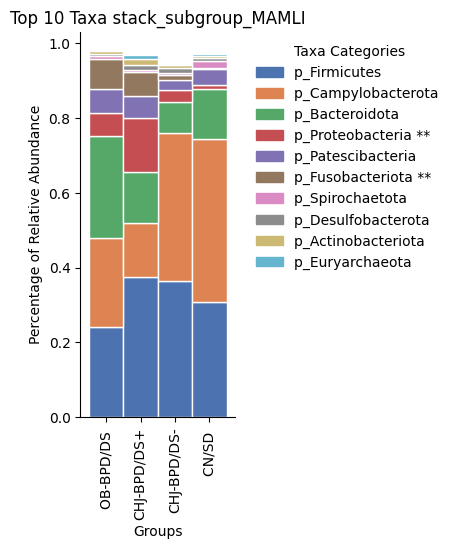

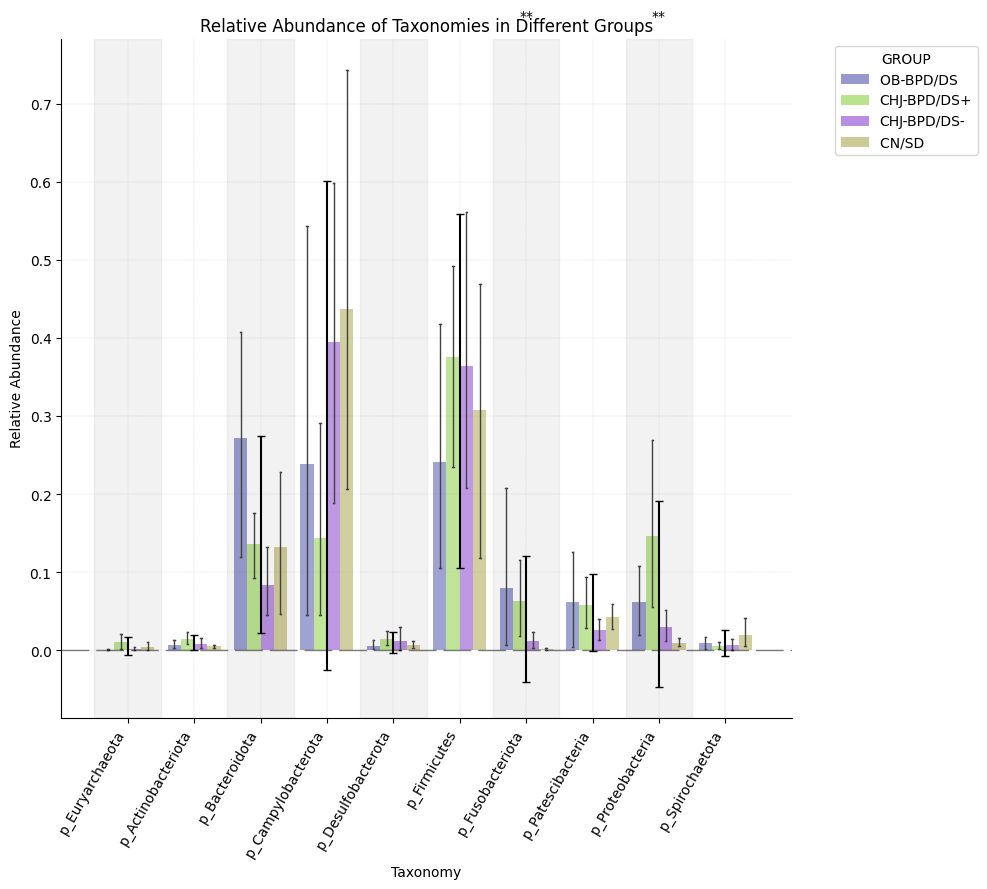

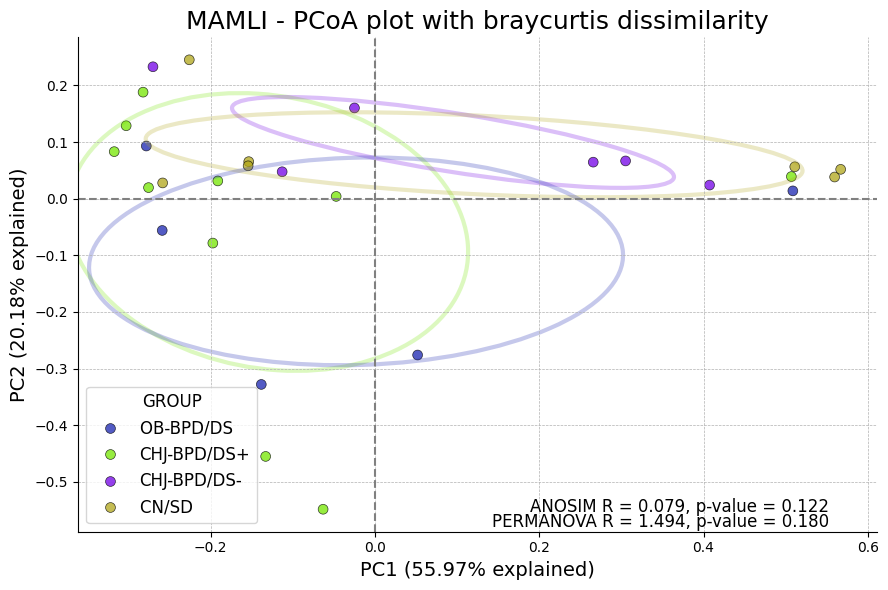

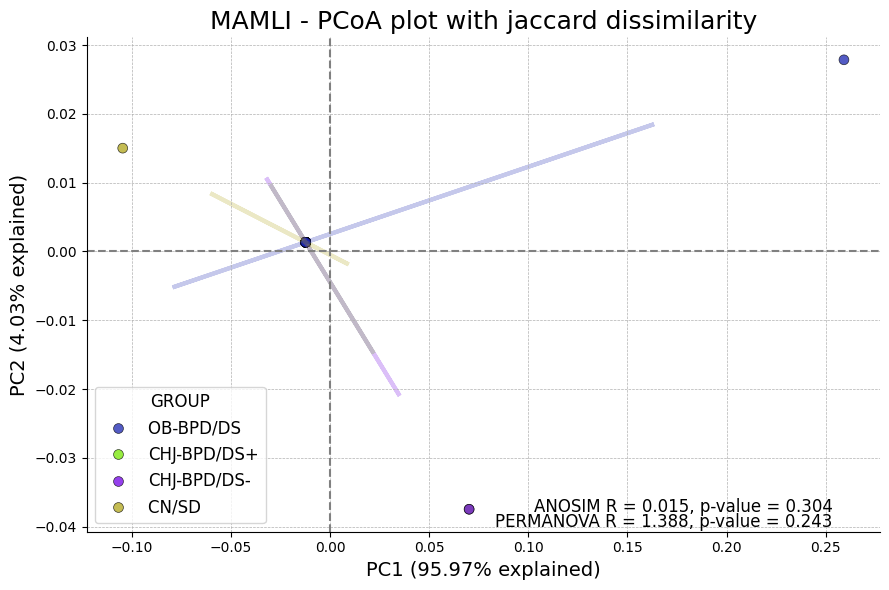

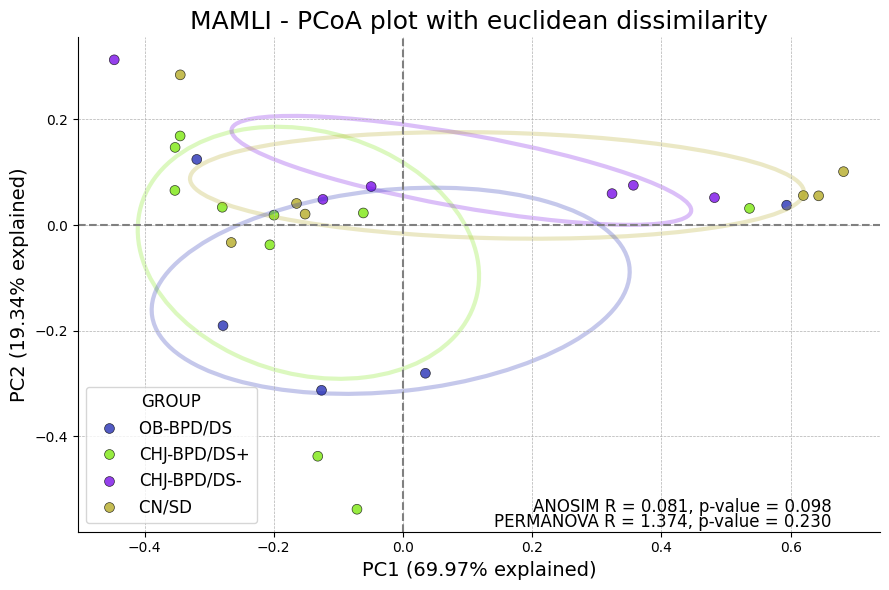

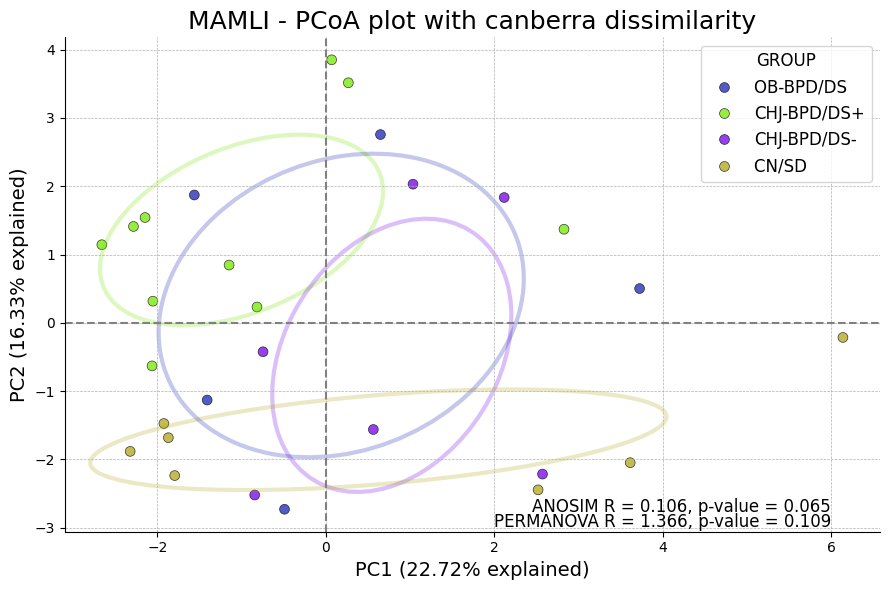

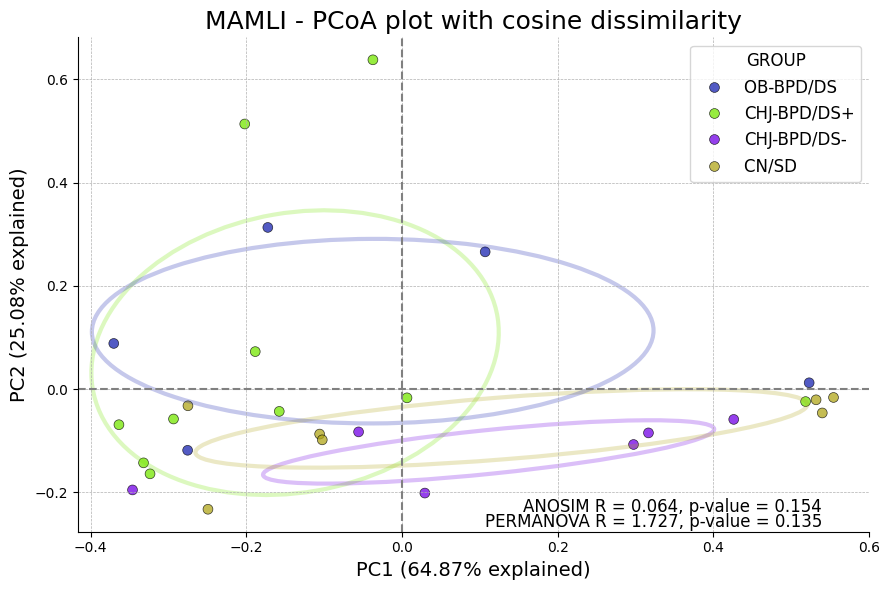


=== Analyzing Subgroup: MAM-D ===

=== SHANNON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.593712   3.0  2.130036  0.124067
Residual  2.136955  23.0       NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.3783  0.1148 -0.8229  0.0663   False
1  CHJ-BPD/DS+       CN/SD    -0.0514  0.9867 -0.4765  0.3737   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.0325  0.9974 -0.5030  0.4380   False
3  CHJ-BPD/DS-       CN/SD     0.3269  0.2446 -0.1424  0.7962   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.3458  0.2667 -0.1650  0.8566   False


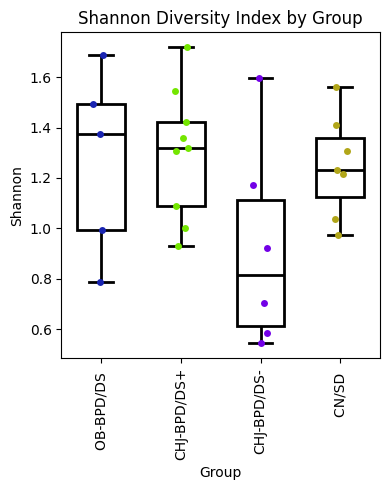


=== SIMPSON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.160877   3.0  2.415999  0.092386
Residual  0.510509  23.0       NaN       NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1792  0.1316 -0.3965  0.0381   False
1  CHJ-BPD/DS+       CN/SD    -0.0101  0.9991 -0.2179  0.1977   False
2  CHJ-BPD/DS+   OB-BPD/DS     0.0295  0.9842 -0.2004  0.2595   False
3  CHJ-BPD/DS-       CN/SD     0.1691  0.2027 -0.0602  0.3985   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.2087  0.1241 -0.0409  0.4584   False


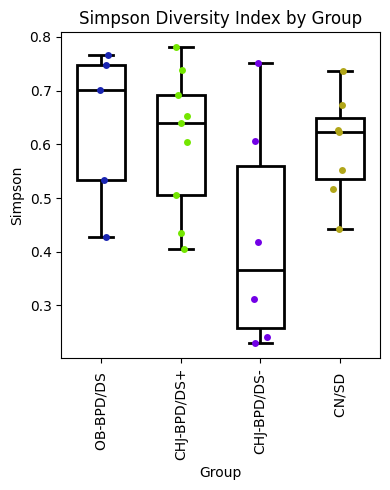


=== OBSERVED ANOVA ===
              sum_sq    df         F    PR(>F)
C(GROUP)   5.738095   3.0  2.324109  0.101514
Residual  18.928571  23.0       NaN       NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.5000  0.7248 -1.8231  0.8231   False
1  CHJ-BPD/DS+       CN/SD     0.2857  0.9230 -0.9794  1.5509   False
2  CHJ-BPD/DS+   OB-BPD/DS    -1.0000  0.2258 -2.4003  0.4003   False
3  CHJ-BPD/DS-       CN/SD     0.7857  0.4218 -0.6110  2.1824   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.5000  0.7996 -2.0202  1.0202   False


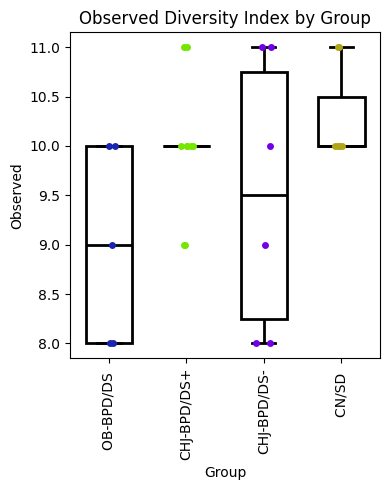


=== PIELOU_E ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.104591   3.0  2.000885  0.141953
Residual  0.400754  23.0       NaN       NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1541  0.1488 -0.3467  0.0384   False
1  CHJ-BPD/DS+       CN/SD    -0.0306  0.9671 -0.2146  0.1535   False
2  CHJ-BPD/DS+   OB-BPD/DS     0.0078  0.9996 -0.1960  0.2115   False
3  CHJ-BPD/DS-       CN/SD     0.1236  0.3550 -0.0796  0.3268   False
4  CHJ-BPD/DS-   OB-BPD/DS     0.1619  0.2079 -0.0593  0.3831   False


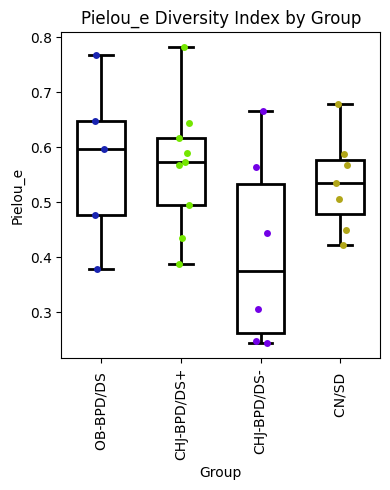

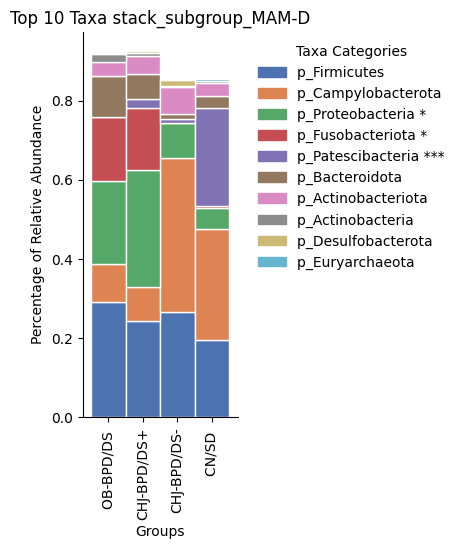

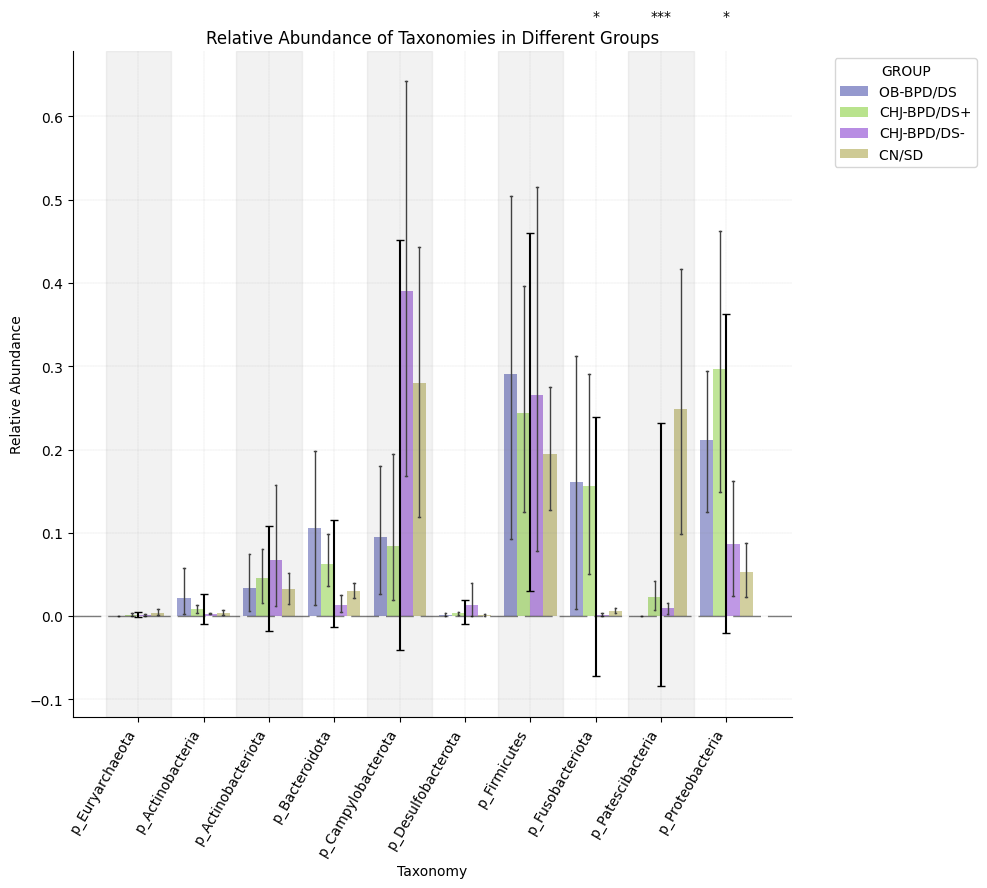

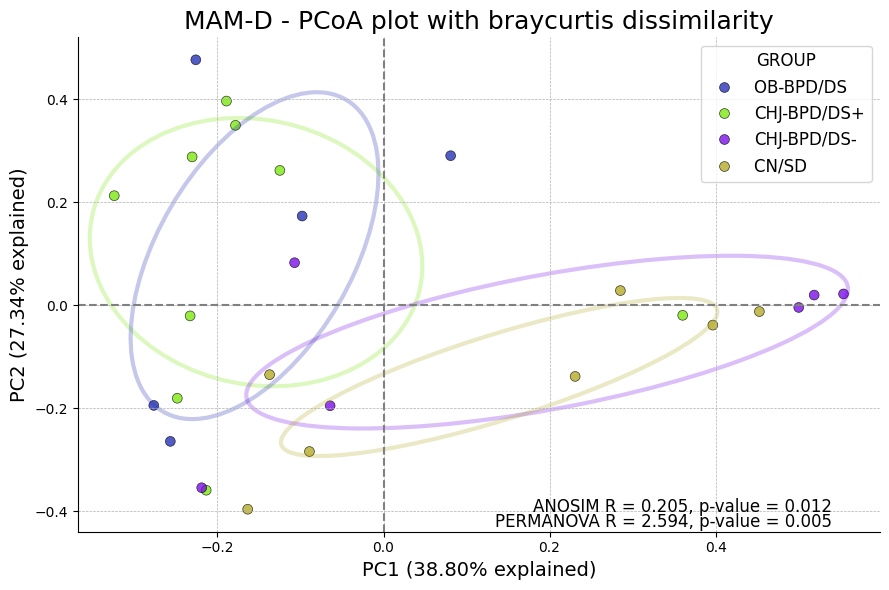

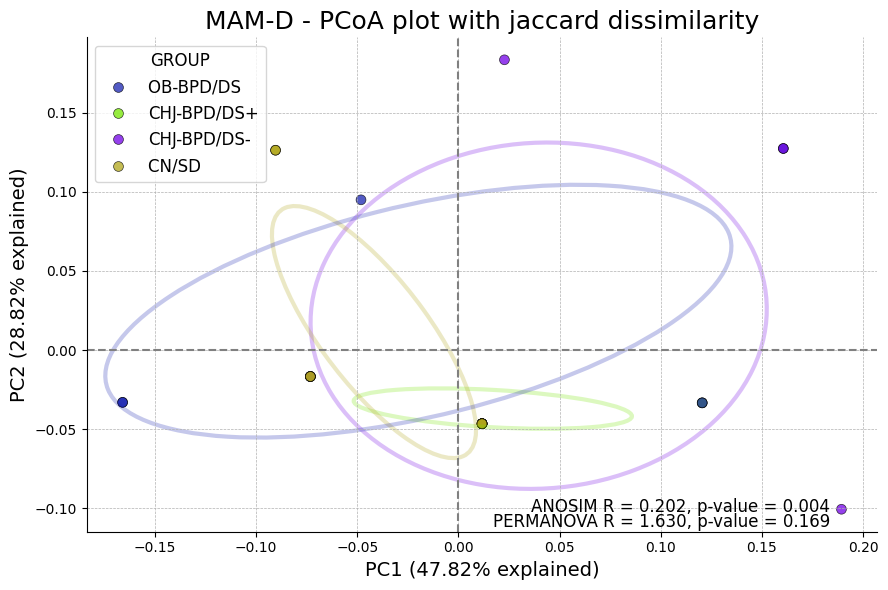

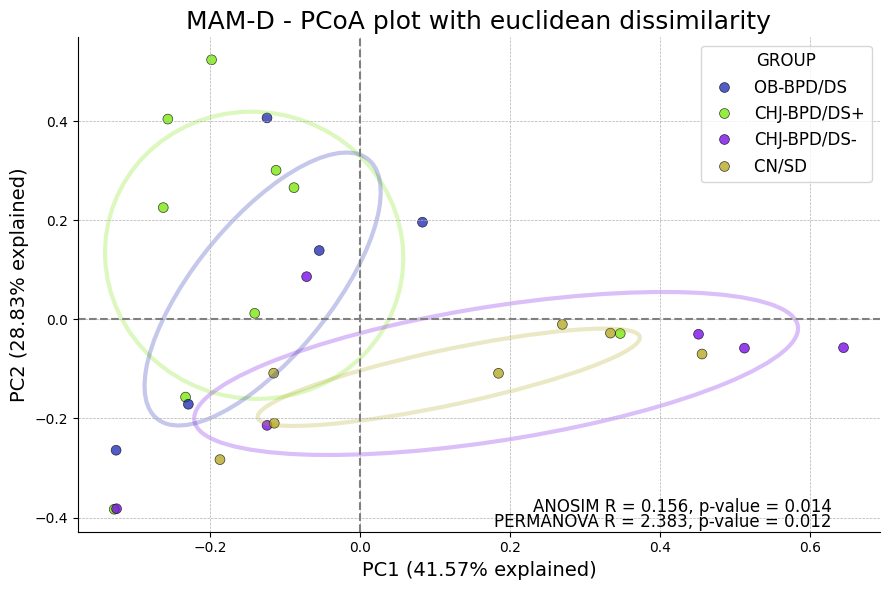

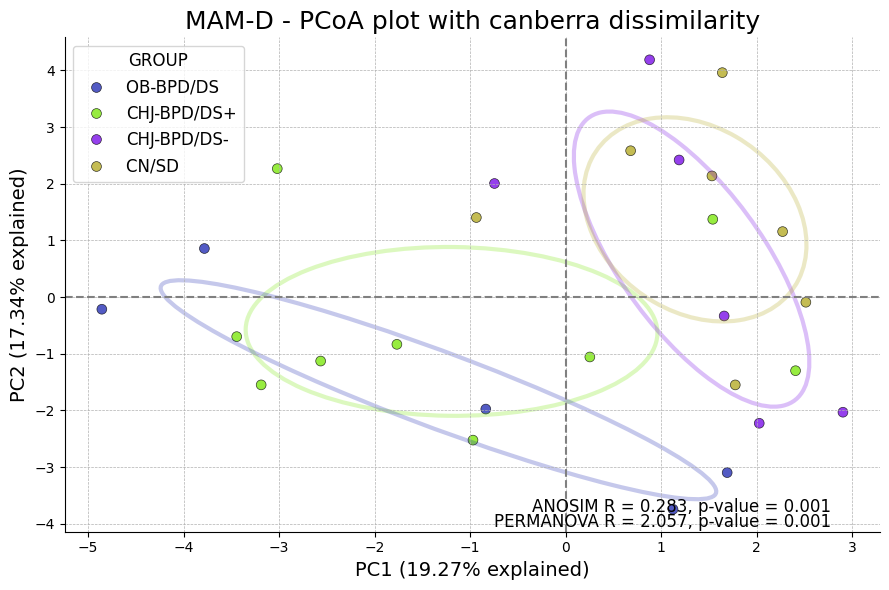

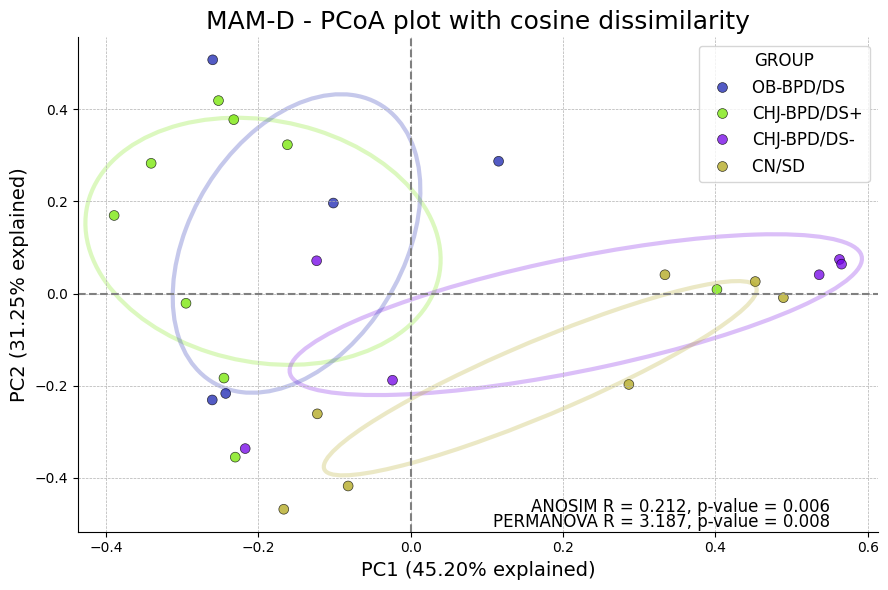


=== Analyzing Subgroup: Fecal ===

=== SHANNON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.310851   3.0  1.799185  0.183428
Residual  1.036638  18.0       NaN       NaN
=== SHANNON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.1426  0.6940 -0.5089  0.2237   False
1  CHJ-BPD/DS+       CN/SD    -0.0520  0.9843 -0.4674  0.3633   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.3304  0.1481 -0.7457  0.0849   False
3  CHJ-BPD/DS-       CN/SD     0.0905  0.9355 -0.3473  0.5284   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.1878  0.6272 -0.6256  0.2500   False


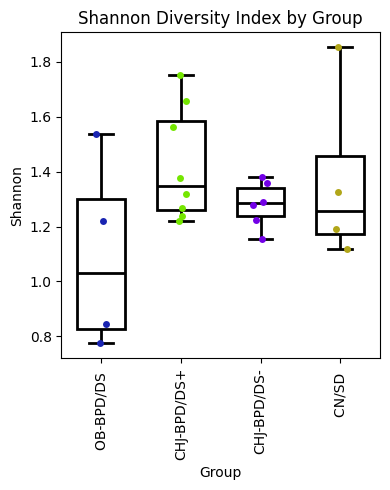


=== SIMPSON ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.073408   3.0  1.974959  0.153881
Residual  0.223017  18.0       NaN       NaN
=== SIMPSON Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.0421  0.8955 -0.2120  0.1278   False
1  CHJ-BPD/DS+       CN/SD    -0.0100  0.9988 -0.2027  0.1826   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.1595  0.1259 -0.3521  0.0332   False
3  CHJ-BPD/DS-       CN/SD     0.0321  0.9694 -0.1710  0.2352   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.1174  0.3859 -0.3204  0.0857   False


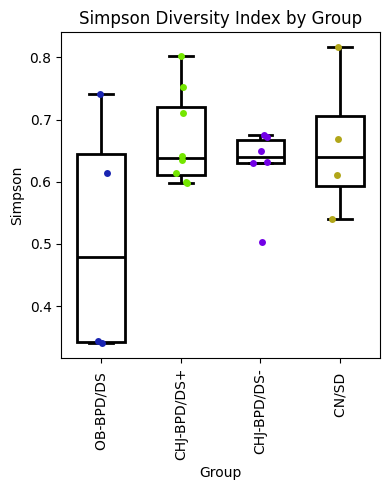


=== OBSERVED ANOVA ===
             sum_sq    df         F    PR(>F)
C(GROUP)  0.079545   3.0  0.545455  0.657483
Residual  0.875000  18.0       NaN       NaN
=== OBSERVED Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-     0.125  0.7232 -0.2115  0.4615   False
1  CHJ-BPD/DS+       CN/SD      0.125  0.7915 -0.2566  0.5066   False
2  CHJ-BPD/DS+   OB-BPD/DS      0.125  0.7915 -0.2566  0.5066   False
3  CHJ-BPD/DS-       CN/SD      0.000  1.0000 -0.4022  0.4022   False
4  CHJ-BPD/DS-   OB-BPD/DS      0.000  1.0000 -0.4022  0.4022   False


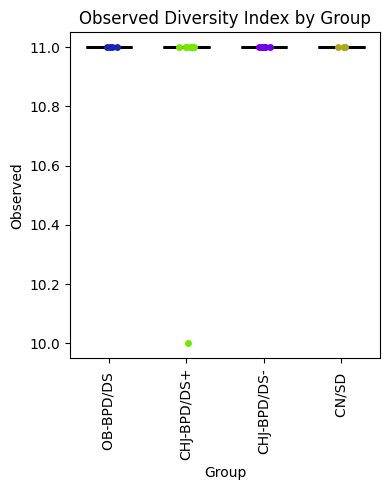


=== PIELOU_E ANOVA ===
             sum_sq    df        F    PR(>F)
C(GROUP)  0.056078   3.0  1.89185  0.167162
Residual  0.177852  18.0      NaN       NaN
=== PIELOU_E Tukey ===
         group1       group2  meandiff   p-adj   lower   upper  reject
0  CHJ-BPD/DS+  CHJ-BPD/DS-   -0.0622  0.6594 -0.2139  0.0895   False
1  CHJ-BPD/DS+       CN/SD    -0.0244  0.9774 -0.1965  0.1476   False
2  CHJ-BPD/DS+   OB-BPD/DS    -0.1405  0.1331 -0.3126  0.0315   False
3  CHJ-BPD/DS-       CN/SD     0.0378  0.9343 -0.1436  0.2191   False
4  CHJ-BPD/DS-   OB-BPD/DS    -0.0783  0.6222 -0.2597  0.1030   False


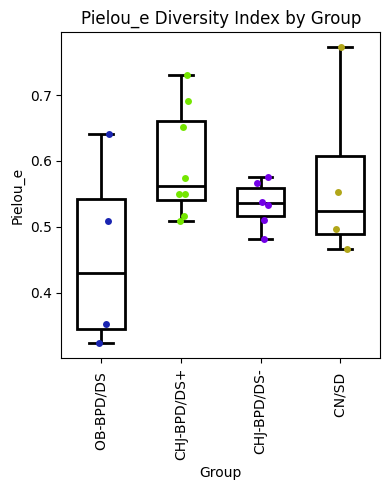

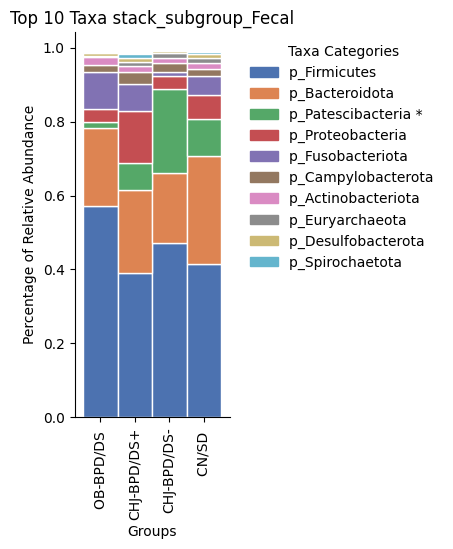

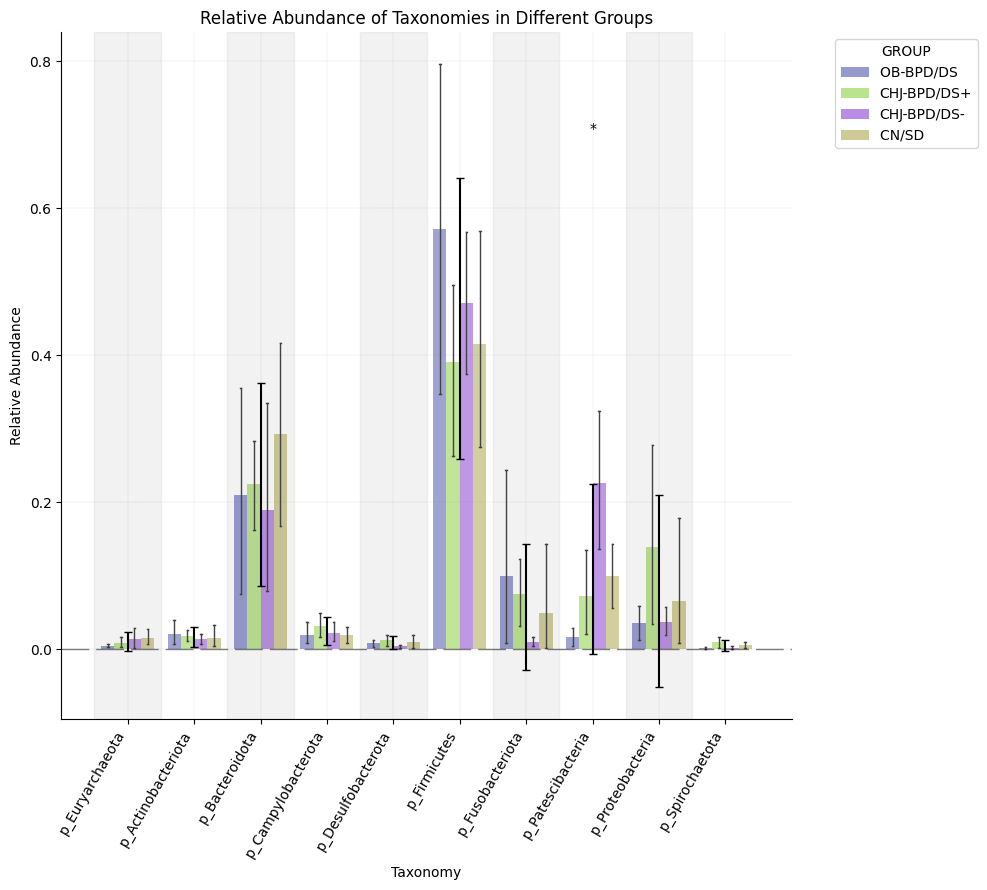

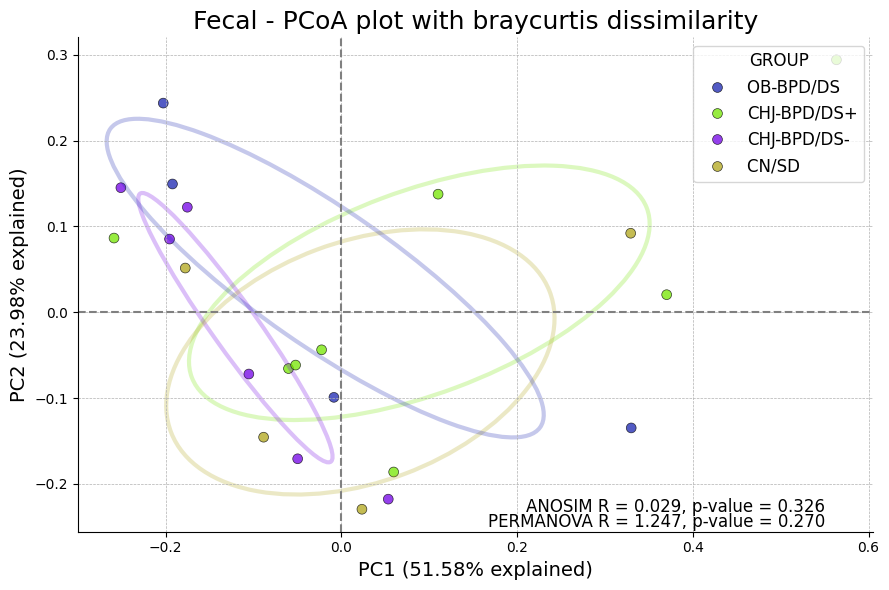

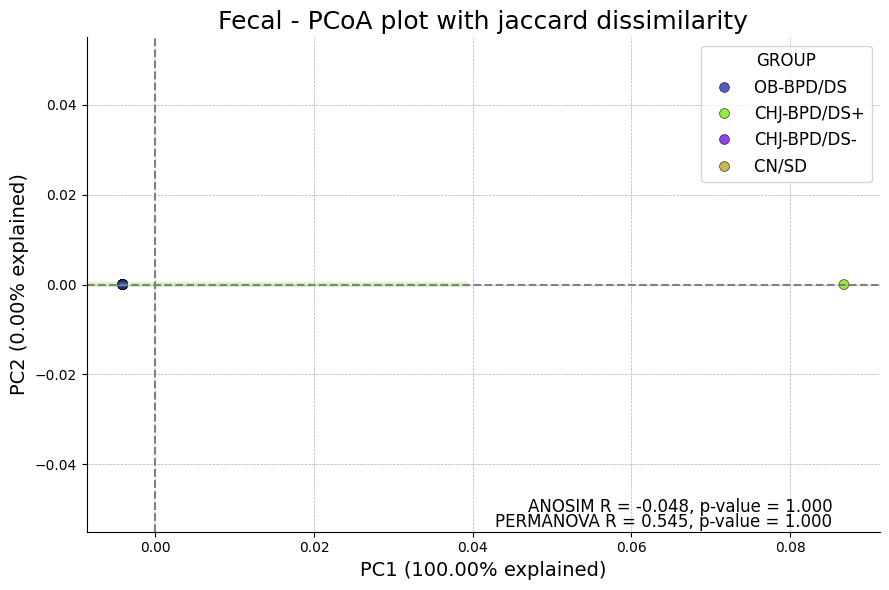

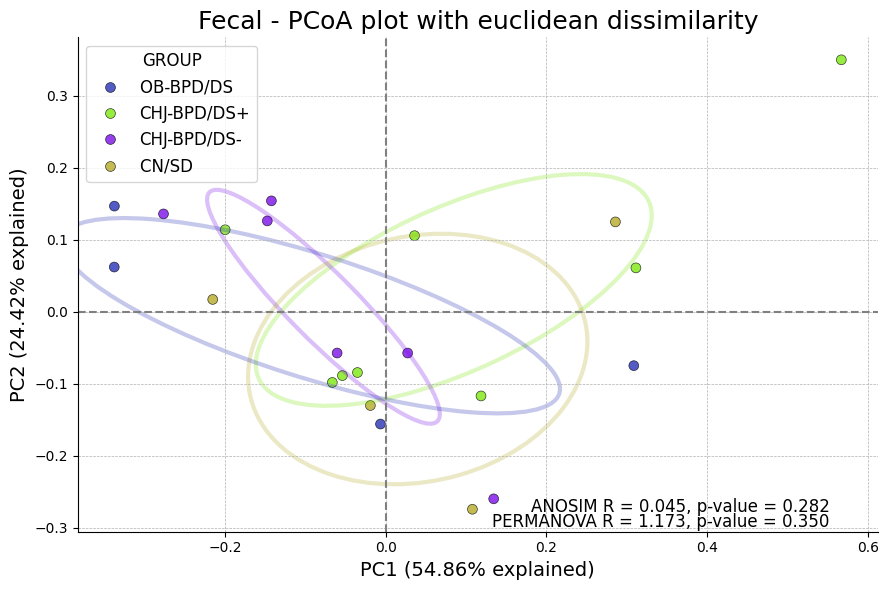

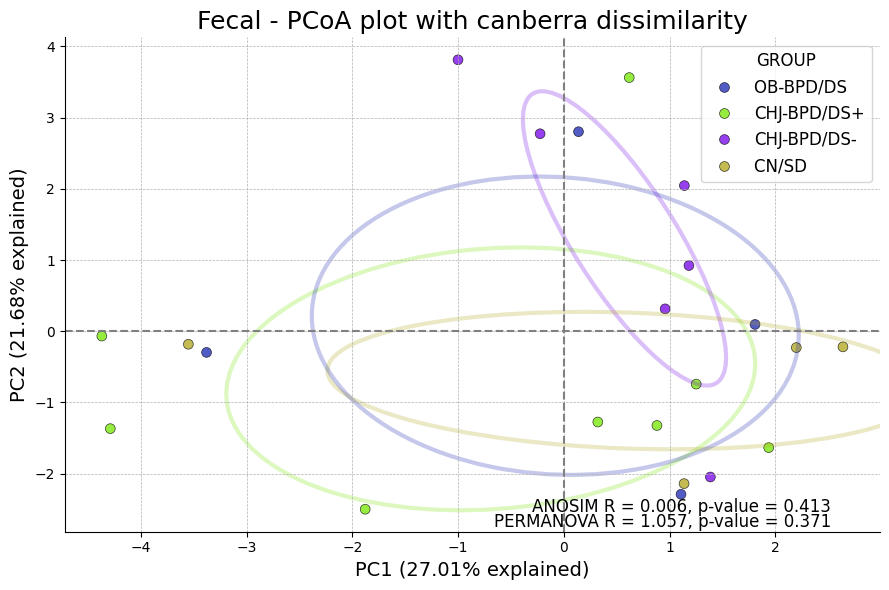

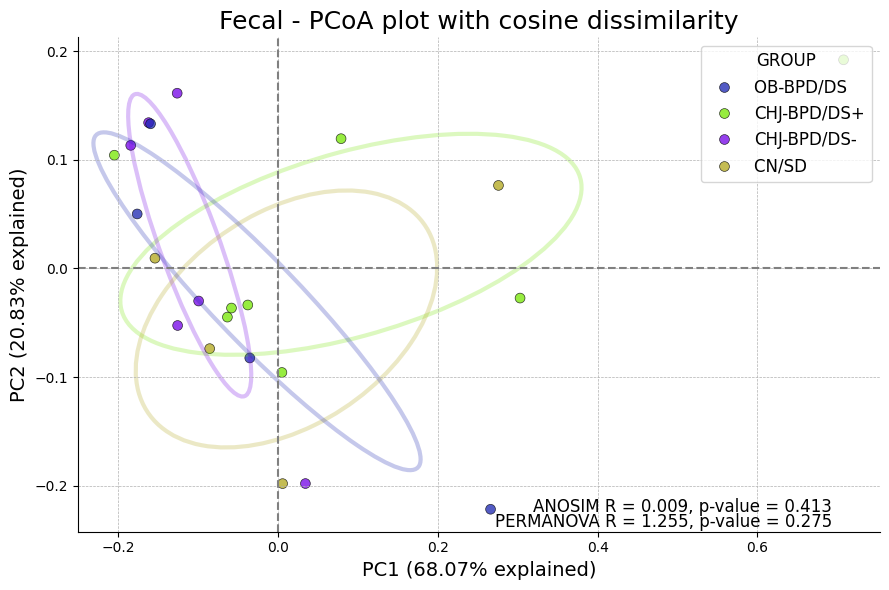

In [14]:
results_dict = msa.analyze_all_subgroups(df_filtered_phylum, SUPGROUP_LIST, group_list=GROUP_LIST)